In [37]:
import jax
jax.config.update("jax_default_device",jax.devices()[2])
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax import jit,grad,jacfwd,jacrev,vmap
import numpy as np
import matplotlib.pyplot as plt
import jax
from tqdm.auto import tqdm
plt.style.use("ggplot")

from importlib import reload
import KernelTools
reload(KernelTools)
from KernelTools import *
from Kernels import *
from EquationModel import *
from jax.scipy.linalg import solve
from EquationModel import *
from GP_sampler import *

In [38]:
#u_data = jnp.load("darcy_example_data/u_vals.npy")
x_grid=jnp.linspace(0,1,25)
y_grid=jnp.linspace(0,1,25)
X,Y=jnp.meshgrid(x_grid,y_grid)
pairs = jnp.vstack([X.ravel(), Y.ravel()]).T
# def u_true_function1(xy):
#     x = xy[0]
#     y = xy[1]
#     return jnp.exp(jnp.sin(1*(jnp.cos(2*x) + jnp.cos(3*y))))

# def u_true_function2(xy):
#     x = xy[0]
#     y = xy[1]
#     return jnp.exp(0.2 * (jnp.sin(1*(jnp.cos(5*x) - jnp.cos(4*y)))))

# def u_true_function3(xy):
#     x = xy[0]
#     y = xy[1]
#     return jnp.sin(2 * x) * jnp.cos(3 * y)
u_true_function1,u_true_function2, u_true_function3 = GP_sampler(num_samples = 3,
                                        X = pairs, 
                                        kernel = 'rbf',
                                        len_scale = 1., 
                                        reg = 1e-12,
                                        seed = 2024
                                    )  


def A(xy):
    x = xy[0]
    y = xy[1]
    return jnp.exp(jnp.sin(jnp.cos(x) + jnp.cos(y)))

def get_rhs_darcy(u):
    def Agradu(xy):
        return A(xy)*jax.grad(u)(xy)
    def Pu(xy):
        return jnp.trace(jax.jacfwd(Agradu)(xy))
    return Pu

u_true_functions = [u_true_function1,u_true_function2, u_true_function3]
rhs_funcs = [jax.vmap(get_rhs_darcy(u)) for u in u_true_functions]
vmapped_u_true_functions = [jax.vmap(u) for u in u_true_functions]

In [39]:
def build_xy_grid(x_range,y_range,num_grid_x,num_grid_y):
    full_x_grid = jnp.linspace(x_range[0],x_range[1],num_grid_x)
    full_y_grid = jnp.linspace(y_range[0],y_range[1],num_grid_y)

    x_interior = full_x_grid[1:-1]
    y_interior = full_y_grid[1:-1]
    
    x_boundary = full_x_grid[jnp.array([0,-1])]
    y_boundary = full_y_grid[jnp.array([0,-1])]

    #Get interior points
    x,y = jnp.meshgrid(x_interior,y_interior)
    xy_interior = jnp.vstack([x.flatten(),y.flatten()]).T

    #I'm doing this with meshgrid to handle more general higher dimensions, ie circular domain in 2d
    #Get boundary points
    x,y = jnp.meshgrid(x_interior,y_boundary)
    xy_boundary_1 = jnp.vstack([x.flatten(),y.flatten()]).T

    x,y = jnp.meshgrid(x_boundary,y_interior)
    xy_boundary_2 = jnp.vstack([x.flatten(),y.flatten()]).T

    x,y = jnp.meshgrid(x_boundary,y_boundary)
    xy_boundary_3 = jnp.vstack([x.flatten(),y.flatten()]).T

    xy_boundary = jnp.vstack([xy_boundary_1,xy_boundary_2,xy_boundary_3])
    return xy_interior,xy_boundary

In [40]:
xy_int,xy_bdy = build_xy_grid((0,1),(0,1),50,50)

In [74]:
num_grid_points = 12
# Ghost grid - Same per function
xy_int,xy_bdy = build_xy_grid([0,1],[0,1],num_grid_points,num_grid_points)
xy_all = jnp.vstack([xy_bdy,xy_int])


u_true1, u_true2, utrue3 = [fn(xy_all) for fn in vmapped_u_true_functions]


def get_obs(num_obs, xy_int, xy_bdy,vmapped_u_true_functions, vmapped_rhs, seed):
    """
        Gets samples(functions) of GP. 

        Args:
            num_obs (list): List of integers of number of observed points per function.
            xy_int (jnp.array): Interior domain to get the sample.
            xy_bdy (jnp.array): Boundary domain.
            vmapped_u_true_functions (list): List of vmapped u true functions.
            vmapped_u_true_functions (list): List of vmapped f true functions.
            seed (int): Integer to fix the simulation.

        Returns:
            list: List of lists xy_obs, u_obs, f_obs.   
    """

    if len(num_obs) != len(vmapped_u_true_functions):
        raise Exception("len of list of provided observed points not same as len of list of provided functions.")
    
    num_f = len(vmapped_rhs)
    key = jax.random.PRNGKey(seed)
    seed = jax.random.randint(key=key, shape=(num_f,), minval=1, maxval=40)
    xy_obs, u_obs, f_obs =  [], [], []
    for i, num_ob in enumerate(num_obs):
        xy_sample_indsi = np.random.choice(list(np.arange(len(xy_int))),num_ob,replace = False)
        xy_obsi = jnp.vstack([xy_bdy,xy_int[xy_sample_indsi]])
        xy_obs.append(xy_obsi)
        u_obs.append(vmapped_u_true_functions[i](xy_obsi))
        f_obs.append(rhs_funcs[i](xy_obsi))
    return xy_obs, u_obs, f_obs

# Number of observed points per u
num_obs = [3,4,2]

xy_obs, u_obs, f_obs = get_obs(num_obs, xy_int, xy_bdy,vmapped_u_true_functions, rhs_funcs, seed=2024)

xy_obs1,xy_obs2,xy_obs3 = xy_obs
u_obs1,u_obs2,u_obs3 = u_obs
f_obs1,f_obs2,f_obs3 = f_obs

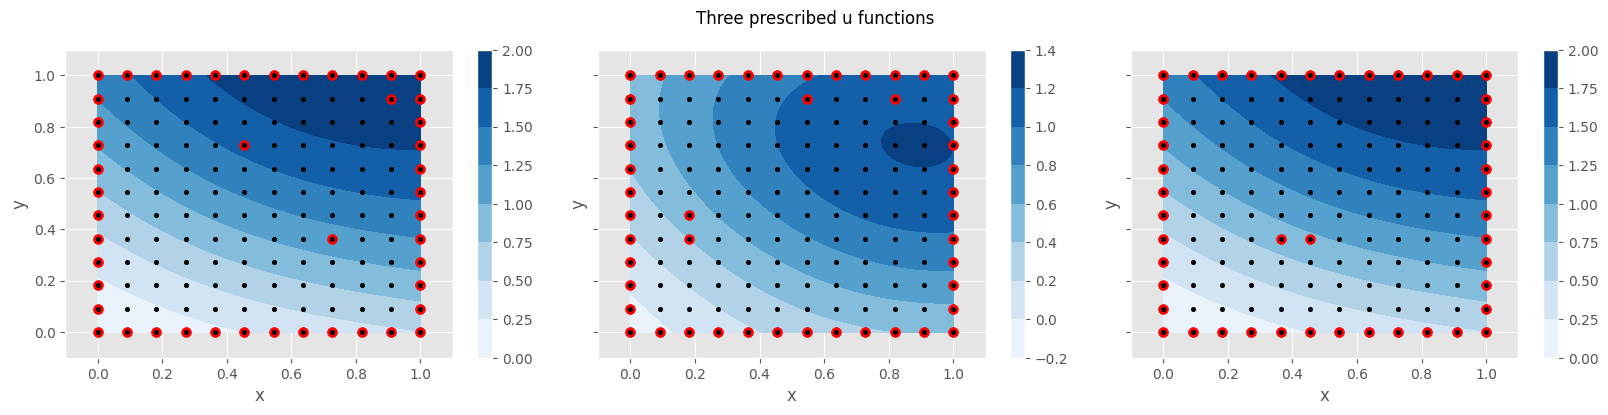

In [75]:
# Plot u's
num_fine_grid = 100
x_fine,y_fine = np.meshgrid(np.linspace(0,1,num_fine_grid),np.linspace(0,1,num_fine_grid))
xy_fine = np.vstack([x_fine.flatten(),y_fine.flatten()]).T


fig, axs = plt.subplots(figsize = (20,4), nrows =1 , ncols = 3, sharex = True, sharey = True)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
fig.suptitle('Three prescribed u functions')
axs0 = axs[0].tricontourf(xy_fine[:,0],xy_fine[:,1],vmapped_u_true_functions[0](xy_fine),cmap = 'Blues')
plt.colorbar(axs0, ax = axs[0])
axs[0].scatter(xy_obs1[:,0],xy_obs1[:,1],c='red', s = 50)
axs[0].scatter(xy_all[:,0],xy_all[:,1],c='black',s = 10)
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].set_xlim(-0.1,1.1)
axs[0].set_ylim(-0.1,1.1)
axs1 = axs[1].tricontourf(xy_fine[:,0],xy_fine[:,1],vmapped_u_true_functions[1](xy_fine),cmap = 'Blues')
plt.colorbar(axs1, ax = axs[1])
axs[1].scatter(xy_obs2[:,0],xy_obs2[:,1],c='red', s = 50)
axs[1].scatter(xy_all[:,0],xy_all[:,1],c='black',s = 10)
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')
axs[1].set_xlim(-0.1,1.1)
axs[1].set_ylim(-0.1,1.1)
axs2 = axs[2].tricontourf(xy_fine[:,0],xy_fine[:,1],vmapped_u_true_functions[0](xy_fine),cmap = 'Blues')
plt.colorbar(axs2, ax = axs[2])
axs[2].scatter(xy_obs3[:,0],xy_obs3[:,1],c='red', s = 50)
axs[2].scatter(xy_all[:,0],xy_all[:,1],c='black',s = 10)
axs[2].set_xlabel('x')
axs[2].set_ylabel('y')
axs[2].set_xlim(-0.1,1.1)
axs[2].set_ylim(-0.1,1.1)
plt.show()
#

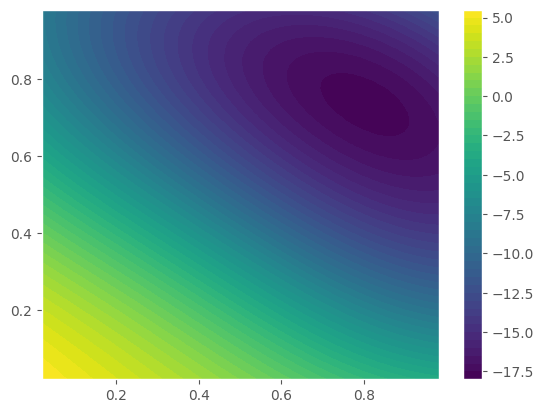

In [7]:
plt.tricontourf(xy_int[:,0],xy_int[:,1],rhs_funcs[1](xy_int),50)
plt.colorbar()

In [19]:
def get_ux(u):
    def ux(x):
        return jax.grad(u)(x)[0]
    return jax.vmap(ux)

def get_uy(u):
    def uy(x):
        return jax.grad(u)(x)[1]
    return jax.vmap(uy)

In [20]:
u1x = get_ux(u_true_function1)

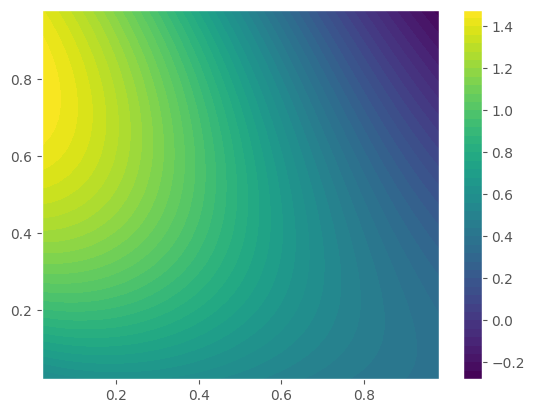

In [21]:
plt.tricontourf(xy_int[:,0],xy_int[:,1],u1x(xy_int),50)
plt.colorbar()